In [1]:
from numpy import *
import pandas as pd
from scipy.stats import norm
from scipy.stats import uniform
from scipy.integrate import quad
from scipy.integrate import dblquad
from scipy.optimize import root_scalar as root
from scipy.stats import multivariate_normal as binorm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import matplotlib as mpl
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['legend.title_fontsize'] = 0

In [2]:
''' read kappas (rows are times and columns are rhos) 
    new notation is z1 = kappa* '''

Kappa_star = pd.read_csv('Kappa_star.csv',index_col=0)
Kappa_star.columns = Kappa_star.columns.astype(float)
Kappa_star.columns = [round(x,3) for x in Kappa_star.columns]
Kappa_star.index = Kappa_star.index.astype(float)
Kappa_star.index = [round(x,3) for x in Kappa_star.index]

''' read parameters '''

params = pd.read_csv('params.csv',index_col=0)
mu = params.loc['mu'].item()
mustar = params.loc['mustar'].item()
sig = params.loc['sig'].item()

print('mu = ' + repr(mu) + ', mustar = ' + repr(mustar) + ', sig = ' + repr(sig))

mu = 105, mustar = 100, sig = 15


In [3]:
''' define boundaries and physical-probability kappas '''

Bdy = mustar - sig * Kappa_star
Kappa = (mu - Bdy) / sig

''' prices and physical expectations '''

def pre_mean(mean,bdy,t,rho) :  # mean = mu or mustar
    kappa = (mean-bdy)/sig
    delta = (1-rho)*kappa / sqrt(1-rho**2)
    cov = array([[1,rho],[rho,1]]) 
    num =  (1+rho)*norm.pdf(kappa)*(t- t**2*norm.cdf(delta))
    Gamma = binorm.cdf(array([-kappa,-kappa]),cov=cov)
    den = 1 - t**2*(1-Gamma) - 2*t*(1-t)*norm.cdf(kappa)
    return mean - sig*num / den

Mean = pd.DataFrame(dtype=float,index=Bdy.index,columns=Bdy.columns)
for t in Bdy.index :
    for rho in Bdy.columns :
        bdy = Bdy.loc[t,rho]
        Mean.loc[t,rho] = pre_mean(mu,bdy,t,rho)

Price = pd.DataFrame(dtype=float,index=Bdy.index,columns=Bdy.columns)
for t in Bdy.index :
    for rho in Bdy.columns :
        bdy = Bdy.loc[t,rho]
        Price.loc[t,rho] = pre_mean(mustar,bdy,t,rho)

''' lists of correlations and times '''

rhos = Bdy.columns.to_list()
times = Bdy.index.to_list()
Times = pd.Series(times,index=times)  # used this later, probably shouldn't have

''' function z in new notation, can input list of times '''

def z0(u) :
    if isinstance(u,list) :
        return array([z0(x) for x in u])
    else :
        def f(z) :  
            fn = u*norm.pdf(z) - z*(1-u*norm.cdf(z))
            first = u*norm.cdf(z) - 1
            second = u*norm.pdf(z) 
            return fn, first, second
        return root(f,x0=1,fprime=True,fprime2=True,method='newton').root

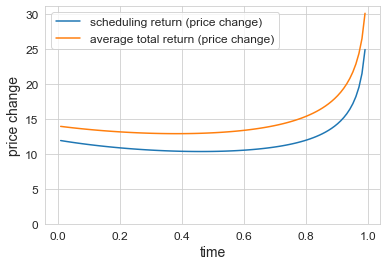

In [4]:
import numpy as np
mustar = -0.5

def price(t,mu) :
    return mu-sig*z0(t)

def pdf(p,mu) :
    return norm.pdf((p-mu)/sig)

def cdf(p,mu) :
    return norm.cdf((p-mu)/sig)

def prob1(t,mu) :
    p = price(t,mustar)
    return t*pdf(p,mu) / (t*pdf(p,mu) + 1 - cdf(p,mu))

def prob2(t,mu) :
    p = price(t,mustar)
    return (1-cdf(p,mu)) / (t*pdf(p,mu) + 1 - cdf(p,mu))

def condmean(t,mu) :
    p = price(t,mustar)
    return mu + sig*pdf(p,mu)/(1-cdf(p,mu))

def mean(t,mu) :
    p = price(t,mustar)
    return prob1(t,mu)*p + prob2(t,mu)*condmean(t,mu)

mu = 105
mustar = 100
sig = 15

ts = np.linspace(0.01,0.99,101)
es = np.array([mean(t,mu) for t in ts])
ps = np.array([mean(t,mustar) for t in ts])
prices = np.array([price(t,mustar) for t in ts])
plt.plot(ts,ps-prices,label='scheduling return (price change)')
plt.plot(ts,es-prices,label='average total return (price change)')
plt.legend()
plt.xlabel('time')
plt.ylim(0,plt.ylim()[1])
plt.ylabel('price change')
plt.savefig('../Figures/NewFig.pdf')

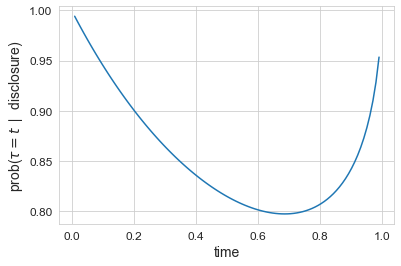

In [47]:
plt.plot(ts,[prob2(t,mu) for t in ts])
plt.xlabel('time')
plt.ylabel(r'prob($\tau=t\,\mid$ disclosure)')
plt.yticks([0.8,0.85,0.9,0.95,1])
plt.savefig('../Figures/ProbJustLearned.pdf')

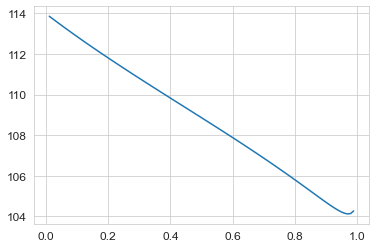

In [39]:
plt.plot(ts,es)

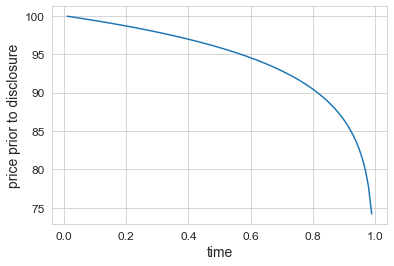

In [83]:
plt.plot(ts,prices)
plt.xlabel('time')
plt.ylabel('price prior to disclosure')
plt.savefig('../Figures/OneFirmPrice.pdf')

### Section 2

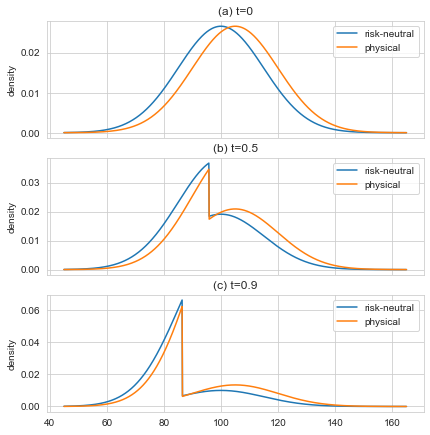

In [5]:
''' Fig 2.2 '''

grid = linspace(mu-4*sig,mu+4*sig,1001)
fig, axes = plt.subplots(3,1,figsize=((6,6)),sharex=True)
fig.tight_layout()
for t, ax in zip([0.00001,0.5,0.9],axes) :
    P = mustar-sig*z0(t)
    denstar = 1-t*norm.cdf((mustar-P)/sig)
    den = 1-t*norm.cdf((mu-P)/sig)
    numstar = [norm.pdf((a-mustar)/sig)/sig if a < P else (1-t)*norm.pdf((a-mustar)/sig)/sig for a in grid]
    num = [norm.pdf((a-mu)/sig)/sig if a < P else (1-t)*norm.pdf((a-mu)/sig)/sig for a in grid]
    ax.plot(grid,numstar/denstar,label='risk-neutral')
    ax.plot(grid,num/den,label='physical')
    ax.legend()
    if t==0.00001 :
        ax.set_title('(a) t=0')
    elif t==0.5 :
        ax.set_title('(b) t=0.5')
    else :
        ax.set_title('(c) t=0.9') 
    ax.set_ylabel('density')
fig.savefig('../Figures/OneFirmDensities.pdf')    

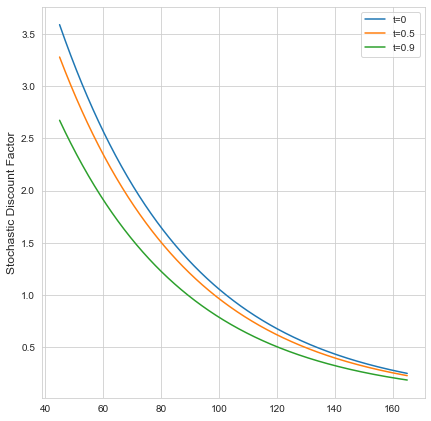

In [9]:
''' SDFs '''

grid = linspace(mu-4*sig,mu+4*sig,1001)
df = pd.DataFrame(dtype=float,index=grid,columns=['0','0.5','0.9'])
fig, ax = plt.subplots(1,1,figsize=((6,6)))
fig.tight_layout()
for t in [0.00001,0.5,0.9] :
    P = mustar-sig*z0(t)
    denstar = 1-t*norm.cdf((mustar-P)/sig)
    den = 1-t*norm.cdf((mu-P)/sig)
    numstar = array([norm.pdf((a-mustar)/sig)/sig if a < P else (1-t)*norm.pdf((a-mustar)/sig)/sig for a in grid])
    num = array([norm.pdf((a-mu)/sig)/sig if a < P else (1-t)*norm.pdf((a-mu)/sig)/sig for a in grid])
    sdf = (numstar/denstar) / (num/den)
    if t==0.00001 :
         ax.plot(grid,sdf,label='t=0')
         df['0'] = sdf
    elif t==0.5 :
        ax.plot(grid,sdf,label='t=0.5')
        df['0.5'] = sdf
    else :
        ax.plot(grid,sdf,label='t=0.9')
        df['0.9'] = sdf
    ax.set_ylabel('Stochastic Discount Factor',fontsize=12)
ax.legend()
fig.savefig('../Figures/OneFirmSDFs.pdf')    

<AxesSubplot:>

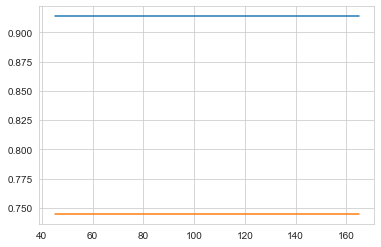

In [11]:
(df['0.5']/df['0']).plot()
(df['0.9']/df['0']).plot()

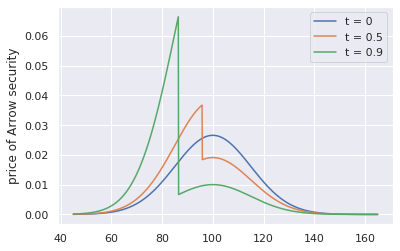

In [118]:
''' didn't use this '''

lam = (mu-mustar) / sig

def m(x) :
    return exp(-lam*(x-mu)/sig)

grid = linspace(mu-4*sig,mu+4*sig,1001)

for t  in [0,0.5,0.9] :
    P = mustar-sig*z0(t)
    prob = 1-t*norm.cdf(mu-P)/sig
    def physdens(x) :
        f = norm.pdf((x-mu)/sig)/sig
        return f/prob if x < P else (1-t)*f/prob
    q1 = quad(lambda x: m(x)*physdens(x), -inf, P)[0]
    q2 = quad(lambda x: m(x)*physdens(x), P, inf)[0]
    Em = q1+q2
    plt.plot(grid,[m(x)*physdens(x)/Em for x in grid],label='t = ' + repr(t))
plt.legend()
plt.ylabel(('price of Arrow security'))
plt.savefig('../Figures/ArrowSecurities.pdf')
        

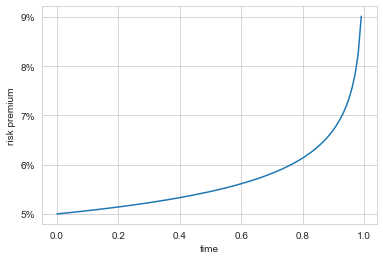

In [6]:
''' Fig 2.2 '''

grid1 = linspace(0.001,0.990,101)
P = array([mustar-sig*z0(t) for t in grid1])
E = array([mu - sig*t*norm.pdf((mu-p)/sig) / (1-t*norm.cdf((mu-p)/sig)) for t, p in zip(grid1,P)])
plt.plot(grid1,E/P-1)
plt.yticks([.05,.06,.07,.08,.09],['5%','6%','7%','8%','9%'])
plt.xlabel('time')
plt.ylabel('risk premium')
plt.savefig('../Figures/OneFirmRiskPremium.pdf')

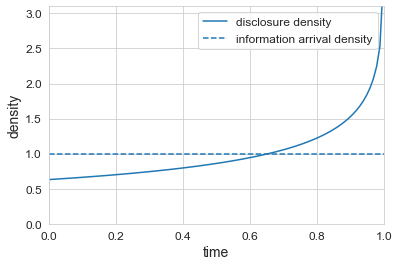

In [82]:
''' Fig 2.4 '''

def density(t) :
    z = z0(t)
    zprime = (norm.pdf(z)+z*norm.cdf(z)) / (1 - t*norm.cdf(z))
    b = mustar - sig*z
    Phi = norm.cdf((mu-b)/sig)
    phi = norm.pdf((mu-b)/sig)
    return Phi + t*phi*zprime

grid1 = linspace(0.001,0.999,101)
d = [density(t) for t in grid1]
plt.plot(grid1,d,label='disclosure density')
plt.xlabel('time')
plt.ylim(0,3.1)
plt.xlim(0,1)
plt.axhline(y=1,linestyle='--',label='information arrival density')
plt.legend()
plt.ylabel('density')
plt.savefig('../Figures/OneFirmC.pdf')

### Section 3 (except simulation figure)

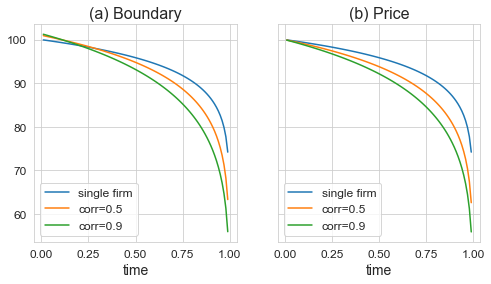

In [49]:
''' Fig 3.1 '''

fig, axes = plt.subplots(1,2,sharey=True,figsize=(8,4))
ax0, ax1 = axes

ax0.plot(times,mustar-sig*z0(times),label='single firm')
ax0.plot(times,Bdy[0.5],label='corr=0.5')
ax0.plot(times,Bdy[0.9],label='corr=0.9')
ax0.set_xlabel('time')
ax0.legend()
ax0.set_title('(a) Boundary')

ax1.plot(times,mustar-sig*z0(times),label='single firm')
ax1.plot(times,Price[0.5],label='corr=0.5')
ax1.plot(times,Price[0.9],label='corr=0.9')
ax1.set_xlabel('time')
ax1.legend()
ax1.set_title('(b) Price')

fig.savefig('../Figures/PricesBdys.pdf')

### Section 4

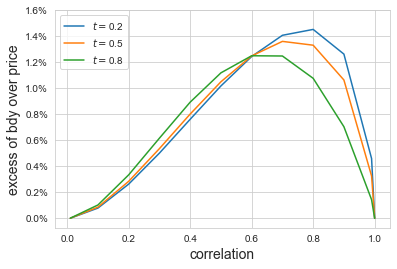

In [9]:
''' Fig 4.1 
    plotted better with old Kappa_star that had finer rho grid 
    Do not overwrite '''

Percent_Option_Value = (Bdy - Price) / Price

for t in [0.2,0.5,0.8] :
    x = Percent_Option_Value.loc[t]
    x.loc[1] = 0
    x.sort_index(inplace=True)
    plt.plot(x.index,x,label='$t= $' + repr(t))

plt.xlabel('correlation',fontsize=14)
plt.ylabel('excess of bdy over price',fontsize=14)
ylabels = [str(round(100*x,1)) +'%' for x in plt.yticks()[0][1:]]
plt.yticks(plt.yticks()[0][1:],ylabels)
plt.legend()
# plt.savefig('../Figures/BdyOverPrice.pdf')

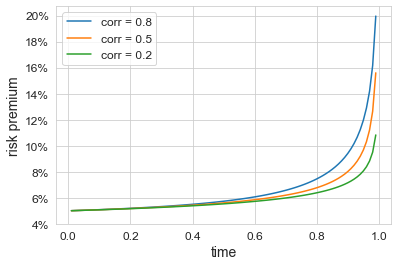

In [19]:
''' Fig 4.2 '''

grid1 = linspace(0.001,0.990,101)
# P = array([mustar-sig*z0(t) for t in grid1])
# E = array([mu - sig*t*norm.pdf((mu-p)/sig) / (1-t*norm.cdf((mu-p)/sig)) for t, p in zip(grid1,P)])
# plt.plot(grid1,E/P-1,label='single firm')

Pre_Premium = pd.DataFrame(dtype=float,index=Bdy.index,columns=Bdy.columns)
for t in Bdy.index :
    for rho in Bdy.columns :
        Pre_Premium.loc[t,rho] =  Mean.loc[t,rho]/Price.loc[t,rho] - 1
        
for rho in [0.8,0.5,0.2] :
    plt.plot(times,Pre_Premium[rho], label=r'corr = ' + repr(round(rho,2)))
plt.xlabel('time',fontsize=14)
plt.ylabel('risk premium',fontsize=14)
plt.legend()
ylabels = [str(int(100*x)) +'%' for x in plt.yticks()[0][:-1]]
plt.yticks(plt.yticks()[0][:-1],ylabels)
plt.savefig('../Figures/RiskPremia.pdf', bbox_inches = "tight")

In [6]:
''' function z2 in new notation '''

def z1(t,u,y) :
    def f(z) :
        fn = t*norm.pdf(y) + (u-t)*norm.pdf(z) - z*(1-t*norm.cdf(y)-(u-t)*norm.cdf(z))
        first = t*norm.cdf(y) + (u-t)*norm.cdf(z) - 1
        second = (u-t)*norm.pdf(z)
        return  fn, first, second
    a = t*norm.pdf(y) / (1-t*norm.cdf(y))
    return root(f,x0=(a+z0(u))/2,fprime=True,fprime2=True,method='newton').root

''' firm 1 price after firm 2 disclosure (old notation: firm 2 discloses first) 
    risk neutral expectation of x1 after disclosure of x2 
    computed as fixed point '''

def firm1_price(t,rho,x2,u) : 
    bdyt = Bdy.loc[t,rho]
    mustar1 = rho*x2 + (1-rho)*mustar
    sig1 = sig * sqrt(1-rho**2)
    y = (mustar1-bdyt) / sig1
    z = z0(u)
    if y <= z:
        return mustar1 - sig1*z
    else :
        return mustar1 - sig1*z1(t,u,y)
    
''' physical expectation of x1 after disclosure of x2 
    use boundary from firm1_price fixed point ''' 

def firm1_expected(t,rho,x2,u) :
    bdyt = Bdy.loc[t,rho]
    mu1 = rho*x2 + (1-rho)*mu
    sig1 = sig * sqrt(1-rho**2)
    bdyu = firm1_price(t,rho,x2,u)   # price and bdy are same in Stage 2
    if bdyu <= bdyt :
        a = (mu1-bdyu) / sig1
        return mu1 - sig1 * u*norm.pdf(a) / (1-u*norm.cdf(a))
    else :
        a_t = (mu1-bdyt) / sig1
        a_u = (mu1-bdyu) / sig1
        return mu1 - sig1 * ( (t*norm.pdf(a_t)+(u-t)*norm.pdf(a_u)) / (1-t*norm.cdf(a_t)-(u-t)*norm.cdf(a_u)) )       

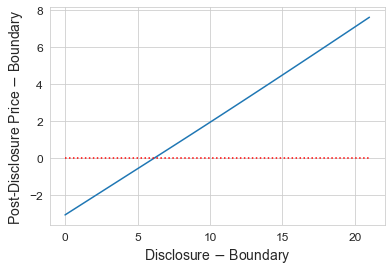

In [13]:
b = Bdy.loc[0.2,0.5]
grid = linspace(b,mu+sig,100)
p = [firm1_price(0.2,0.5,x,0.5) for x in grid]
plt.plot(grid-b,p-b)
plt.xlabel(r'Disclosure $-$ Boundary')
plt.ylabel(r'Post-Disclosure Price $-$ Boundary')
plt.plot(grid-b, [0]*len(grid), color='red', ls = ':')
plt.savefig('../Figures/DisclosurePostDisclosure.pdf')

Text(0.5, 0, 'time')

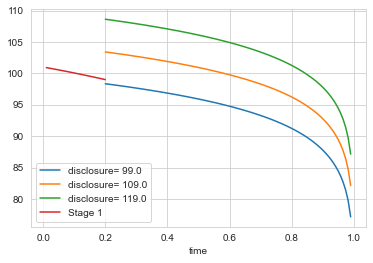

In [12]:
b = Bdy.loc[0.2,0.5]
x2 = b
grid = linspace(0.2,0.99,100)
p = [firm1_price(0.2,0.5,x2,u) for u in grid]
plt.plot(grid,p,label='disclosure= ' + repr(round(x2,1)))
x2 = x2+10
p = [firm1_price(0.2,0.5,x2,u) for u in grid]
plt.plot(grid,p,label='disclosure= ' + repr(round(x2,1)))
x2 = x2+10
p = [firm1_price(0.2,0.5,x2,u) for u in grid]
plt.plot(grid,p,label='disclosure= ' + repr(round(x2,1)))
plt.plot(Bdy.loc[:0.2,0.5],label='Stage 1')
plt.legend()
plt.xlabel('time')
# plt.savefig('../Figures/Clustering.pdf')

In [51]:
''' Compute derivative of boundary as weighted average of left-hand side and right-hand side derivatives 
    Weight more on point (t+ or t-) that is closest to t (points are evenly spaced except at beginning and end)
'''

Deriv = pd.DataFrame(dtype=float,index=Bdy.index,columns=Bdy.columns)
for rho in Bdy.columns :
    right = Bdy[rho].diff().shift(-1) / Times.diff().shift(-1)    # [ B(t+) - B(t) ] / [ t+ - t ]
    left = Bdy[rho].diff() / Times.diff()                         # [ B(t) - B(t-) ] / [ t - t- ]
    right_wt = Times.diff() / Times.diff(2).shift(-1)             # [ t - t- ] / [ t+ - t-]
    Deriv[rho] = right_wt*right + (1-right_wt)*left
    
''' Have to use one-sided derivatives for first and last time '''

for rho in Bdy.columns :
    Deriv[rho].iloc[0] = (Bdy[rho].iloc[1] - Bdy[rho].iloc[0]) / (Times.iloc[1] - Times.iloc[0])
    Deriv[rho].iloc[-1] = (Bdy[rho].iloc[-1] - Bdy[rho].iloc[-2]) / (Times.iloc[-1] - Times.iloc[-2])
    
def t_times(df) :  # multiplies each column of df by the array of times
    return df.apply(lambda x: asarray(x)*times)

''' probabilities and densities '''

phi_star = pd.DataFrame(norm.pdf(Kappa_star),index=Kappa_star.index,columns=Kappa_star.columns)
Phi_star = pd.DataFrame(norm.cdf(Kappa_star),index=Kappa_star.index,columns=Kappa_star.columns)
phi = pd.DataFrame(norm.pdf(Kappa),index=Kappa.index,columns=Kappa.columns)
Phi = pd.DataFrame(norm.cdf(Kappa),index=Kappa.index,columns=Kappa.columns)

''' arrival rates '''

Above_Rate_star = Phi_star / ( 1 - t_times(Phi_star) )
At_Rate_star = (1/sig)*t_times(phi_star)*Deriv.abs() / ( 1 - t_times(Phi_star) )
Above_Rate = Phi / ( 1 - t_times(Phi) )
At_Rate = (1/sig)*t_times(phi)*Deriv.abs() / ( 1 - t_times(Phi) )

''' means of truncated normals '''

Mean_Above_star = mustar + sig * phi_star / Phi_star
Mean_Above = mu + sig * phi / Phi

''' risk-neutral and physical expectations conditioning on scheduling '''

Firm2_Price_Scheduled = ( Above_Rate_star*Mean_Above_star + At_Rate_star*Bdy ) / ( Above_Rate_star + At_Rate_star)
Firm2_Value_Expected = ( Above_Rate*Mean_Above + At_Rate*Bdy ) / ( Above_Rate + At_Rate)

''' scheduling and expected announcement returns for first firm to disclose '''

Firm2_Return_Scheduled = Firm2_Price_Scheduled / Price - 1
Firm2_Return_Total_Expected = Firm2_Value_Expected / Price - 1
Firm2_Return_Announcement_Expected = Firm2_Value_Expected / Firm2_Price_Scheduled - 1

''' risk-neutral expectation of of firm 1's post-announcement price conditional on an announcement being scheduled '''

def firm1_price_scheduled(t,rho) :
    at_rate = At_Rate_star.loc[t,rho]
    above_rate = Above_Rate_star.loc[t,rho]
    bdyt = Bdy.loc[t,rho]
    at_mean = firm1_price(t,rho,bdyt,t)   # firm 1's price when firm 2 discloses at the bounday
    # now compute risk-neutral expected price conditional on x2>bdy
    # prob*(x2>bdy) = prob*((x2-mustar)/sig > (bdy-mustar)/sig) = prob*((mustar-x)/sig < (mustar-bdy)/sig) = Phi(kappa_star)
    prob = Phi_star.loc[t,rho]
    above_mean = (1/prob) * quad(lambda x: firm1_price(t,rho,x,t)*norm.pdf((x-mustar)/sig)/sig,at_mean,inf)[0]
    return ( at_rate*at_mean + above_rate*above_mean) / ( at_rate+above_rate)

def firm1_return_scheduled(t,rho) :
    return firm1_price_scheduled(t,rho) / Price.loc[t,rho] - 1

''' physical expectation of firm 1's post-announcement price conditional on an announcement being scheduled '''

def firm1_price_expected(t,rho) :
    at_rate = At_Rate.loc[t,rho]
    above_rate = Above_Rate.loc[t,rho]
    bdyt = Bdy.loc[t,rho]
    at_mean = firm1_price(t,rho,bdyt,t)    # firm 1's price when firm 2 discloses at the boundary
    # now compute physical expectation of price conditional on x2>bdy
    # prob(x2>bdy) = prob((x2-mu)/sig > (bdy-mu)/sig) = prob((mu-x)/sig < (mu-bdy)/sig) = Phi(kappa)
    prob = Phi.loc[t,rho]
    above_mean = (1/prob) * quad(lambda x: firm1_price(t,rho,x,t)*norm.pdf((x-mu)/sig)/sig,at_mean,inf)[0]
    return ( at_rate*at_mean + above_rate*above_mean) / ( at_rate+above_rate)

def firm1_return_total_expected(t,rho) :
    return firm1_price_expected(t,rho) / Price.loc[t,rho] - 1

def firm1_return_announcement_expected(t,rho) :
    return firm1_price_expected(t,rho) / firm1_price_scheduled(t,rho) - 1


In [60]:
''' Fig 4.3 - calculations '''

rho = 0.5
scheduled = [firm1_return_scheduled(t,rho) for t in times]
announcement = [firm1_return_announcement_expected(t,rho) for t in times]
total = [firm1_return_total_expected(t,rho) for t in times]

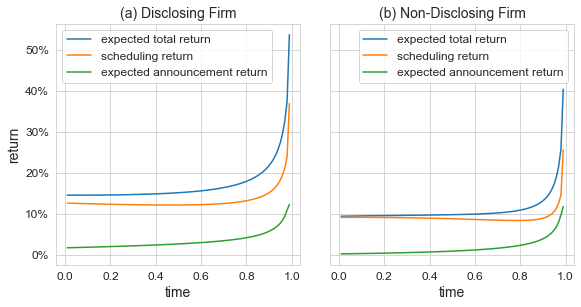

In [61]:
''' Fig 4.3 - plot '''

fig, axes = plt.subplots(1,2,figsize=((8,4)),sharey=True)
fig.tight_layout()
    
axes[0].plot(Firm2_Return_Total_Expected.loc[times,rho], label='expected total return')
axes[0].plot(Firm2_Return_Scheduled.loc[times,rho], label='scheduling return')
axes[0].plot(Firm2_Return_Announcement_Expected.loc[times,rho], label='expected announcement return')
axes[0].set_yticks([0,0.1,0.2,0.3,0.4,0.5,])
axes[0].set_yticklabels(['0%','10%','20%','30%','40%','50%'])
axes[0].set_xlabel('time',fontsize=14)
axes[0].set_ylabel('return',fontsize=14)
axes[0].set_title('(a) Disclosing Firm',fontsize=14)
axes[0].legend()

axes[1].plot(times,total,label='expected total return')
axes[1].plot(times,scheduled,label='scheduling return')
axes[1].plot(times,announcement,label='expected announcement return')
axes[1].set_xlabel('time',fontsize=14)
axes[1].set_title('(b) Non-Disclosing Firm',fontsize=14)
axes[1].legend()

fig.savefig('../Figures/Announcements.pdf', bbox_inches = "tight")

In [64]:
Firm2_Return_Announcement_Expected.loc[times,rho]

0.01    0.017287
0.02    0.017429
0.03    0.017571
0.04    0.017715
0.05    0.017860
          ...   
0.95    0.077183
0.96    0.084464
0.97    0.094390
0.98    0.109350
0.99    0.122598
Name: 0.5, Length: 99, dtype: float64

In [66]:
pd.Series(announcement,index=times)

0.01    0.002495
0.02    0.002566
0.03    0.002639
0.04    0.002714
0.05    0.002791
          ...   
0.95    0.060466
0.96    0.068630
0.97    0.079984
0.98    0.097451
0.99    0.117627
Length: 99, dtype: float64

### Simulation figures

In [53]:
''' read simulations '''

df = pd.read_csv('Sims.csv',index_col=['rho','sim'])

C:\Users\kerry\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


C:\Users\kerry\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


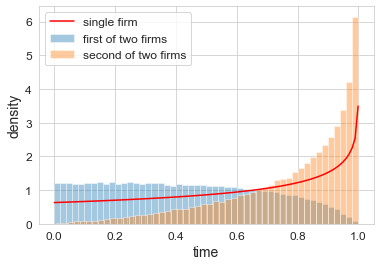

In [57]:
''' Fig 3.2 '''

X = df.xs(0.5,level='rho')
sns.distplot(X.tau1,kde=False,norm_hist=True,label='first of two firms')
sns.distplot(X.tau2,kde=False,norm_hist=True,label='second of two firms')
plt.plot(grid1,d,color='red',label='single firm')
plt.legend()
plt.xlabel('time')
plt.ylabel('density')
plt.savefig('../Figures/MultipleDensities.pdf')

C:\Users\kerry\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


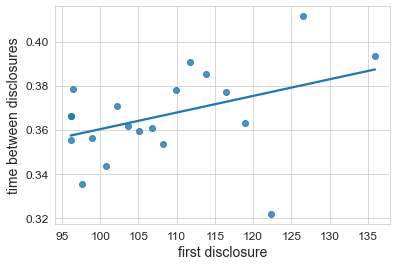

In [74]:
X = df.xs(0.5,level='rho').copy()
X['deltat'] = X['tau2'] - X['tau1']
X['bint'] = pd.qcut(X['tau1'],101,labels=range(1,102))
X = X[X.bint==51]
X['binx'] = pd.qcut(X['x1'],20,labels=range(1,21))
sns.regplot(X.groupby('binx').x1.mean(),X.groupby('binx').deltat.mean(),ci=None)
plt.xlabel('first disclosure')
plt.ylabel('time between disclosures')
plt.savefig('../Figures/Clustering.pdf')

In [76]:
X = df.xs(0.5,level='rho').copy()
X['deltat'] = X['tau2'] - X['tau1']
X['bint'] = pd.qcut(X['tau1'],101,labels=range(1,102))
X = X[X.bint==51]
X.tau1.min()

0.4116845013250242

In [77]:
X.tau1.max()

0.4202514506650318

Text(0, 0.5, 'time between disclosures')

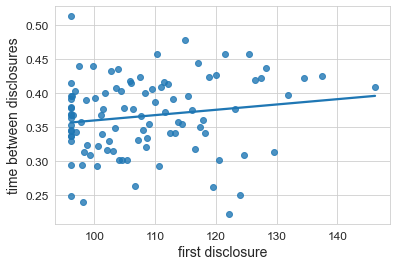

In [81]:
X = df.xs(0.5,level='rho').copy()
X['deltat'] = X['tau2'] - X['tau1']
X['bint'] = pd.qcut(X['tau1'],101,labels=range(1,102))
X = X[X.bint==51]
X['binx'] = pd.qcut(X['x1'],100,labels=range(1,101))
sns.regplot(X.groupby('binx').x1.mean(),X.groupby('binx').deltat.mean(),ci=None)
plt.xlabel('first disclosure')
plt.ylabel('time between disclosures')


In [80]:
sns.regplot(X.x1,X.deltat,ci=None,alpha=0.5)

C:\Users\kerry\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


TypeError: regplot() got an unexpected keyword argument 'alpha'

In [52]:
X = df.xs(0.5,level='rho').copy()
X['deltat'] = X['tau2'] - X['tau1']
X['bint'] = pd.qcut(X['tau1'],101,labels=range(1,102))
X = X[X.bint==51]
X['binx'] = pd.qcut(X['x1'],20,labels=range(1,21))
D = pd.DataFrame(X.groupby(['binx','bint'])['deltat'].mean()).unstack('bint')
D.columns = X.groupby('bint')['tau1'].mean()
D.index = X.groupby('binx')['x1'].mean()
D.head()

tau1,0.020523,0.061630,0.103384,0.144566,0.185594,0.227205,0.268268,0.310077,0.351493,0.394483,0.437688,0.481192,0.525882,0.570846,0.617209,0.666028,0.716550,0.771175,0.833054,0.915219
x1,,,,,,,,,,,,,,,,,,,,
81.259163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.083743,0.039994
88.702255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.179162,0.159504,0.129737,0.102906,0.055841
92.197321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.247867,0.215983,0.189705,0.162342,0.134995,0.101566,0.058873
94.764964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.333855,0.310606,0.280296,0.258863,0.231547,0.211022,0.178509,0.142465,0.109309,0.058448
96.884447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.415858,0.40795,0.36564,0.338578,0.318794,0.277419,0.255865,0.235963,0.209478,0.181321,0.147321,0.108702,0.063504


In [67]:
import statsmodels.api as sm
X = df.xs(0.5,level='rho').copy()
X['deltat'] = X['tau2'] - X['tau1']
x = sm.add_constant(X[['x1','tau1']])
y = X['deltat']
sm.OLS(y,x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 deltat   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                 3.863e+04
Date:                Thu, 07 Jan 2021   Prob (F-statistic):               0.00
Time:                        10:24:20   Log-Likelihood:                 27151.
No. Observations:              100000   AIC:                        -5.430e+04
Df Residuals:                   99997   BIC:                        -5.427e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5809      0.006     98.445      0.000       0.569       0.592
x1             0.0003   4.95e-05      6.078      0.000       0.000       0.000
tau1          -0.6137      0.003   -244.318      0.000      -0.619      -0.609
==============================================================================
Omnibus:                     4470.200   Durbin-Watson:                   1.402
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5098.556
Skew:                          -0.552   Prob(JB):                         0.00
Kurtosis:                       3.058   Cond. No.                     1.13e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

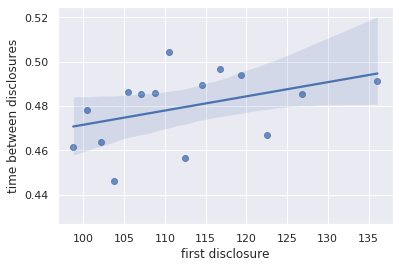

In [60]:
D2 = D[D.columns[5]].dropna()
sns.regplot(D2.index,D2)
plt.xlabel('first disclosure')
plt.ylabel('time between disclosures')
plt.savefig('../Figures/Clustering.pdf')

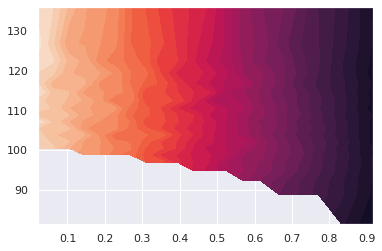

In [54]:
plt.contourf(D.columns,D.index,D,30)

In [ ]:
Z = 100 * (Bdy-Price) / Price
plt.contourf(times,rhos,Z.T,30,cmap='turbo')

In [38]:

meanx = df.groupby(['rho','binx','bint'])['x1'].mean()
meant = df.groupby(['rho','binx','bint'])['tau1'].mean()
Mn = pd.concat((meant,meanx,meand),axis=1)
Mn.head()

tau1          x1    deltat
rho  binx bint                                
0.01 1    1     0.021709  100.312985  0.619028
          2     0.061319   99.948695  0.543436
          3     0.101081   99.527063  0.524592
          4     0.141442   99.147581  0.513790
          5     0.182068   98.797650  0.499042

In [ ]:
X = Mn.xs(0.5,level='rho')
X.reset_index()

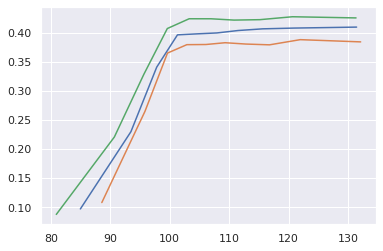

In [27]:

plt.plot(meanx.xs(0.1,level='rho'),meand.xs(0.1,level='rho'), label='corr = ' + repr(rho))
plt.plot(meanx.xs(0.5,level='rho'),meand.xs(0.5,level='rho'), label='corr = ' + repr(rho))
plt.plot(meanx.xs(0.9,level='rho'),meand.xs(0.9,level='rho'), label='corr = ' + repr(rho))
plt.xlabel('first disclosure')
plt.ylabel('time between disclosures')

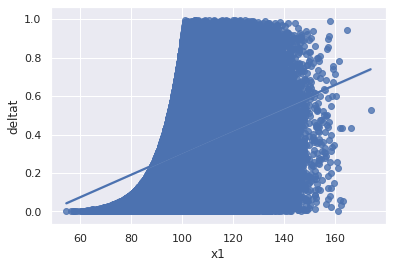

In [23]:
X = df.xs(0.5,level='rho')
sns.regplot(X['x1'],X['deltat'])

### Contour plot examples

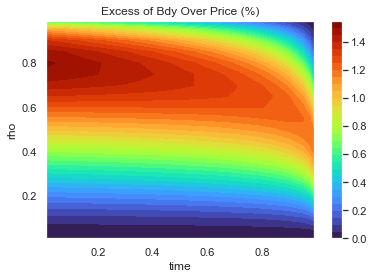

In [15]:
Z = 100 * (Bdy-Price) / Price
plt.contourf(times,rhos,Z.T,30,cmap='turbo')
plt.xlabel('time')
plt.ylabel('rho')
plt.title('Excess of Bdy Over Price (%)')
plt.colorbar()

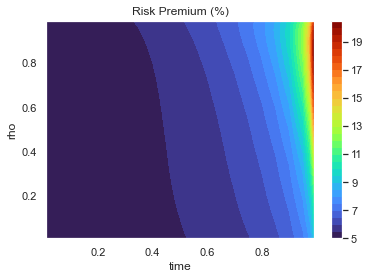

In [16]:
Z = 100 * (Mean-Price) / Price
plt.contourf(times,rhos,Z.T,30,cmap='turbo')
plt.xlabel('time')
plt.ylabel('rho')
plt.title('Risk Premium (%)')
plt.colorbar()

### Average Price

In [53]:
AvgPrice = pd.read_csv('AvgPrice.csv')
AvgPrice['rho'] = AvgPrice.rho.round(2)
AvgPrice.set_index(['rho','sim'],inplace=True)
AvgPrice.columns = AvgPrice.columns.astype(float)
AvgPriceMean = AvgPrice.groupby('rho').mean()

def mandatory_mean(t,rho) :
    return t**2*mu + t*(1-t)*(mu + rho*mu + (1-rho)*mustar) + (1-t)**2*mustar

MandatoryMean = pd.DataFrame(dtype=float,index=AvgPriceMean.index,columns=AvgPriceMean.columns) 
for rho in MandatoryMean.index :
    for t in MandatoryMean.columns :
        MandatoryMean.loc[rho,t] = mandatory_mean(t,rho)
        
DiffMean = (AvgPriceMean - MandatoryMean) / MandatoryMean

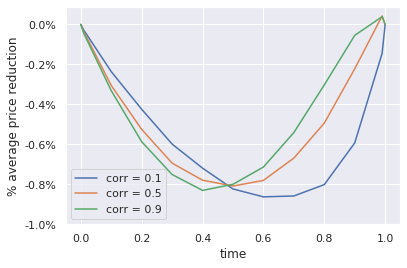

In [54]:
for rho in [0.1,0.5,0.9] :
    xs = [0] + list(DiffMean.loc[rho]) + [0]
    ts = [0] + list(DiffMean.columns) + [1]
    plt.plot(ts,xs,label='corr = ' + repr(rho))
plt.legend()
ylabels = [str(round(100*x,1)) +'%' for x in plt.yticks()[0][:-1]]
plt.yticks(plt.yticks()[0][:-1],ylabels)
plt.xlabel('time')
plt.ylabel('% average price reduction')
plt.savefig('../Figures/AvgPrice.pdf', bbox_inches = "tight")